In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
import os
import DeepFM as dfm
import Preprocess as prep
from sklearn.metrics import roc_curve,confusion_matrix,recall_score,roc_auc_score
import matplotlib.pyplot as plt
import datetime
warnings.filterwarnings('ignore')
path_model='D:\\Github\\projects-1\\DeepFM\\'

In [2]:
train=pd.read_csv('d:\\Github\\projects-1\\Dataset\\train.csv')
item_pool=pd.read_csv('d:\\Github\\projects-1\\Dataset\\item_pool.csv')
item_pool=list(item_pool['oper_obj'])
test=pd.read_csv('d:\\Github\\projects-1\\Dataset\\test.csv')

In [3]:
train_set,test_set=prep.process_data(train,item_pool,test,batch_size=16384,sampling_ratio=4)

In [7]:
#log_dir=path_model+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
model=dfm.DeepFatorizationMachine(256,5000)
if os.path.exists(path_model+'DeepFM.h5'):
    print('loading model.\n')
    model.predict(test_set.take(1))
    model.load_weights(path_model+'DeepFM.h5')
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(0.01),metrics=
    [tf.keras.metrics.BinaryAccuracy(),dfm.roc_auc,tf.keras.metrics.Recall()])
    model.fit(test_set,epochs=5)
    model.evaluate(test_set)
    model.save_weights(path_model+'DeepFM.h5')
else:
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(0.01),metrics=         
    [tf.keras.metrics.BinaryAccuracy(),dfm.roc_auc,tf.keras.metrics.Recall()])
    model.fit(train_set,epochs=30,validation_data=test_set)
    model.evaluate(test_set)
    model.summary()
    model.save_weights(path_model+'DeepFM.h5')

loading model.

Epoch 1/5
3/3 [==============================] - 1s 110ms/step - loss: 0.3699 - binary_accuracy: 0.8562 - roc_auc: 0.8867 - recall_3: 0.4025
Epoch 2/5
3/3 [==============================] - 0s 110ms/step - loss: 0.3529 - binary_accuracy: 0.8682 - roc_auc: 0.9059 - recall_3: 0.4807
Epoch 3/5
3/3 [==============================] - 0s 112ms/step - loss: 0.3032 - binary_accuracy: 0.8704 - roc_auc: 0.9134 - recall_3: 0.4674
Epoch 4/5
3/3 [==============================] - 0s 110ms/step - loss: 0.3051 - binary_accuracy: 0.8782 - roc_auc: 0.9210 - recall_3: 0.5392
Epoch 5/5
3/3 [==============================] - 1s 66ms/step - loss: 0.2694 - binary_accuracy: 0.8856 - roc_auc: 0.9352 - recall_3: 0.5726


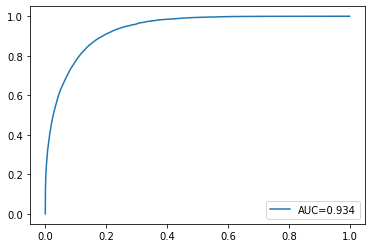

In [8]:
y_true,y_score=dfm.get_prediction(model,test_set)
fpr,tpr,thresholds=roc_curve(y_true,y_score,drop_intermediate=False)
auc=roc_auc_score(y_true,y_score)
plt.plot(fpr,tpr)
plt.legend(['AUC='+str(np.round(auc,3))])
plt.show()

In [9]:
y_pred=np.zeros(len(y_true))
threshold=0.5
y_pred[y_score[:,0]>threshold]=1

In [10]:
recall_score(y_true,y_pred)

0.5725884634028114